In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
# parameters
learning_rate = 0.002
training_epochs = 30
batch_size = 500

In [ ]:
# MNIST dataset
mnist_train = dsets.FashionMNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.FashionMNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



아래와 같이 training set과 test set을 다운받았습니다.

In [ ]:
print(mnist_train.train_data.view(-1, 28 * 28).float().shape)
print(mnist_test.test_data.view(-1, 28 * 28).float().shape)

torch.Size([60000, 784])
torch.Size([10000, 784])


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [ ]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [ ]:
# CNN Model
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5 # for dropout
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
        
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 12, 12, 64) 
        #    Pool      ->(?, 6, 6, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
        
        # L3 FC 6x6x64 inputs -> 600 outputs
        self.fc1 = torch.nn.Linear(6 * 6 * 64, 600, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.drop = torch.nn.Dropout2d(p=0.25)
        
        # L4 FC 600 inputs -> 120 outputs
        self.fc2 = torch.nn.Linear(600, 120, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

        # L5 Final FC 120 inputs -> 10 outputs
        self.fc3 = torch.nn.Linear(120, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:
# instantiate CNN model
model = CNN().to(device)

In [ ]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0

    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        hypothesis = model(image)
        loss = criterion(hypothesis, label)
        loss.backward()
        optimizer.step()

        train_loss += loss / len(train_loader)

    return train_loss

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)

            output = model(image)
            loss = criterion(output, label)
            test_loss += loss / len(test_loader)

            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
# loss value list
loss_keeper = {'train':[], 'test':[]}

for epoch in range(training_epochs):
    train_loss = 0.0
    test_loss = 0.0

    '''
    Training phase
    '''
    train_loss = train(model, train_loader, optimizer)
    train_loss = train_loss.item()
    loss_keeper['train'].append(train_loss)
    
    '''
    Test phase
    '''
    test_loss, test_accuracy = evaluate(model, test_loader)
    test_loss = test_loss.item()
    loss_keeper['test'].append(test_loss)


    print("Epoch:%2d/%2d.. Training loss: %.3f.. Test loss: %.3f.. Test Accuracy: %.3f" 
          %(epoch + 1, training_epochs, train_loss, test_loss, test_accuracy))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1/30.. Training loss: 0.632.. Test loss: 0.391.. Test Accuracy: 0.856
Epoch: 2/30.. Training loss: 0.354.. Test loss: 0.345.. Test Accuracy: 0.875
Epoch: 3/30.. Training loss: 0.313.. Test loss: 0.335.. Test Accuracy: 0.882
Epoch: 4/30.. Training loss: 0.287.. Test loss: 0.299.. Test Accuracy: 0.892
Epoch: 5/30.. Training loss: 0.275.. Test loss: 0.312.. Test Accuracy: 0.887
Epoch: 6/30.. Training loss: 0.261.. Test loss: 0.327.. Test Accuracy: 0.881
Epoch: 7/30.. Training loss: 0.248.. Test loss: 0.284.. Test Accuracy: 0.897
Epoch: 8/30.. Training loss: 0.240.. Test loss: 0.292.. Test Accuracy: 0.900
Epoch: 9/30.. Training loss: 0.233.. Test loss: 0.279.. Test Accuracy: 0.899
Epoch:10/30.. Training loss: 0.220.. Test loss: 0.272.. Test Accuracy: 0.905
Epoch:11/30.. Training loss: 0.216.. Test loss: 0.283.. Test Accuracy: 0.899
Epoch:12/30.. Training loss: 0.216.. Test loss: 0.282.. Test Accuracy: 0.900
Epoch:13/30.. Training loss: 0.209.. Test loss: 0.274.. Test Accuracy: 0.905

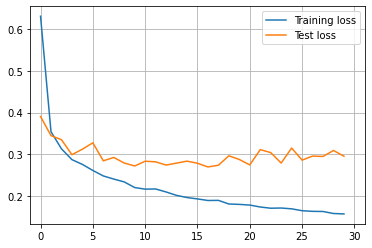

In [ ]:
train_loss_data = loss_keeper['train']
test_loss_data = loss_keeper['test']

plt.plot(train_loss_data, label = "Training loss")
plt.plot(test_loss_data, label = "Test loss")

plt.legend(), plt.grid(True)
plt.xlim(-1,31)
plt.show()